In [1]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [2]:
!ls /content/MyDrive/MyDrive/GEE_SOP/Dataset

Datasets.cpg  Datasets.prj  Datasets.shp  Data_to_Analyze.csv
Datasets.dbf  Datasets.qmd  Datasets.shx


In [3]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 41.2 MB/s eta 0:00:00


In [4]:
import importlib.util

spec = importlib.util.spec_from_file_location("script", '/content/MyDrive/MyDrive/GEE_SOP/modules/script.py')
script_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(script_module)

script_module.Script.work()

it's working!


In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

path = '/content/MyDrive/MyDrive/GEE_SOP/Dataset/Data_to_Analyze.csv'

#sob_data = gpd.read_file(sob_shapefile_path)
data = pd.read_csv(path)

median_mnt1 = data['MNT_1'].median()
data['MNT_1'] = data['MNT_1'].fillna(median_mnt1)

In [12]:
data = data.drop(columns=['Unnamed: 0', 'X_Centroid', 'Y_Centroid','geometry'])
data.columns

Index(['Carbon', 'Epaisseur', 'Profondeur', 'B_1', 'B_2', 'B_3', 'B_4', 'B_5',
       'B_6', 'B_7', 'B_8', 'B_8A', 'B_9', 'B_10', 'B_11', 'B_12', 'MNT_1',
       'NDVI', 'GDVI', 'MSAVI2', 'PSRINIR', 'NDWI', 'CIGreen'],
      dtype='object')

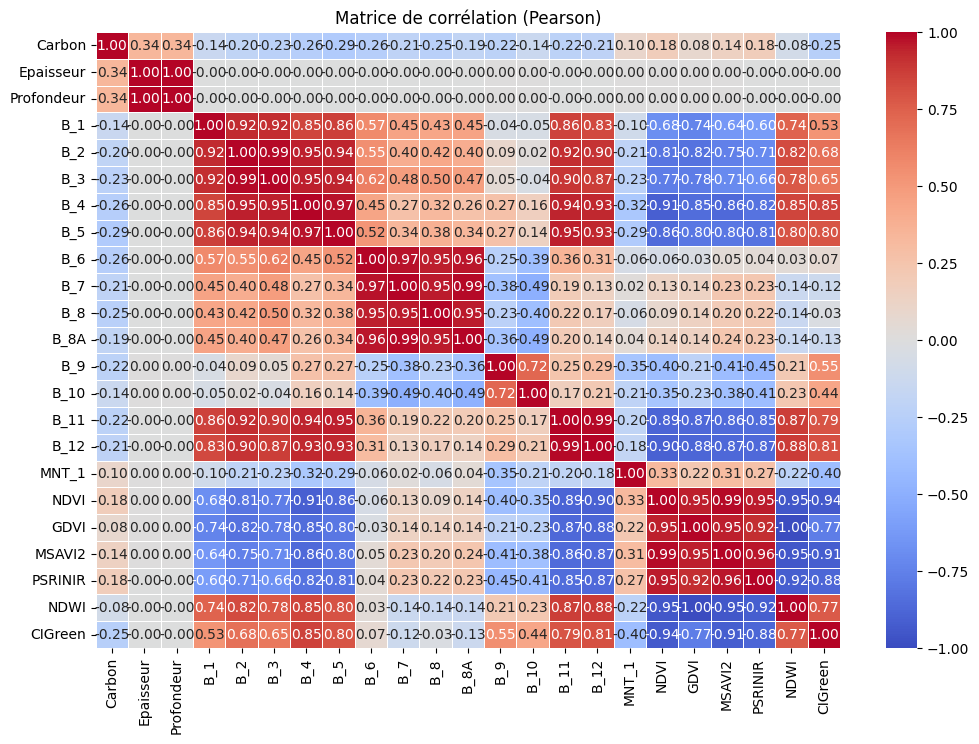

In [13]:
correlation_matrix = data.corr(method="pearson")

plt.figure(figsize=(12, 8))

# Tracer la heatmap de la matrice de corrélation
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Ajouter un titre
plt.title("Matrice de corrélation (Pearson)")

# Afficher la figure
plt.show()

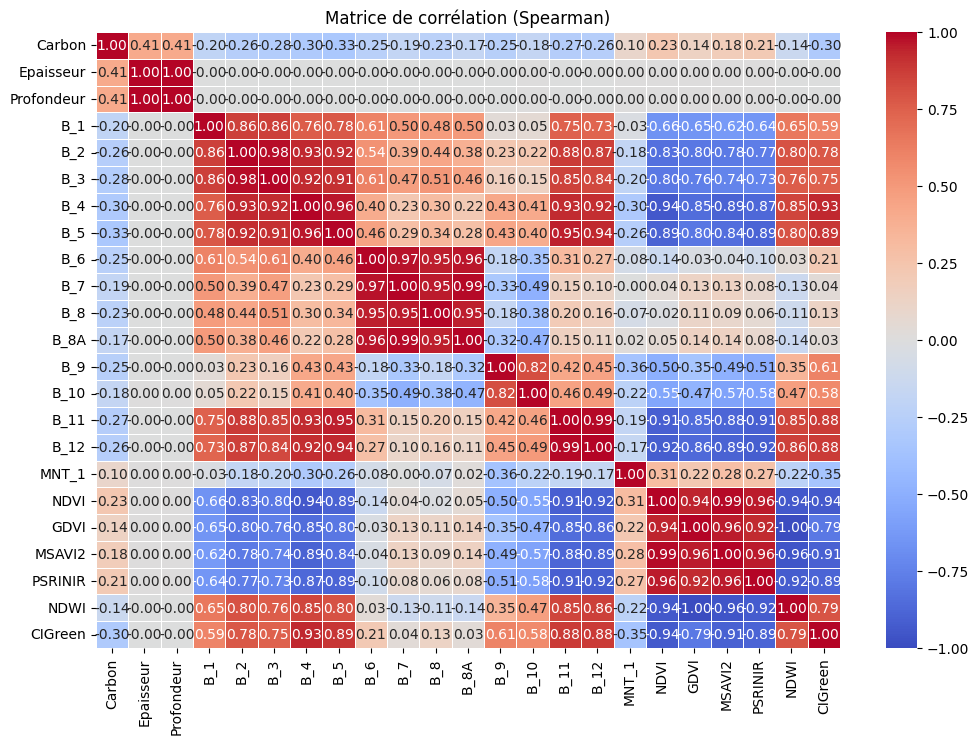

In [14]:
correlation_matrix = data.corr(method='spearman')

plt.figure(figsize=(12, 8))

# Tracer la heatmap de la matrice de corrélation
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Ajouter un titre
plt.title("Matrice de corrélation (Spearman)")

# Afficher la figure
plt.show()


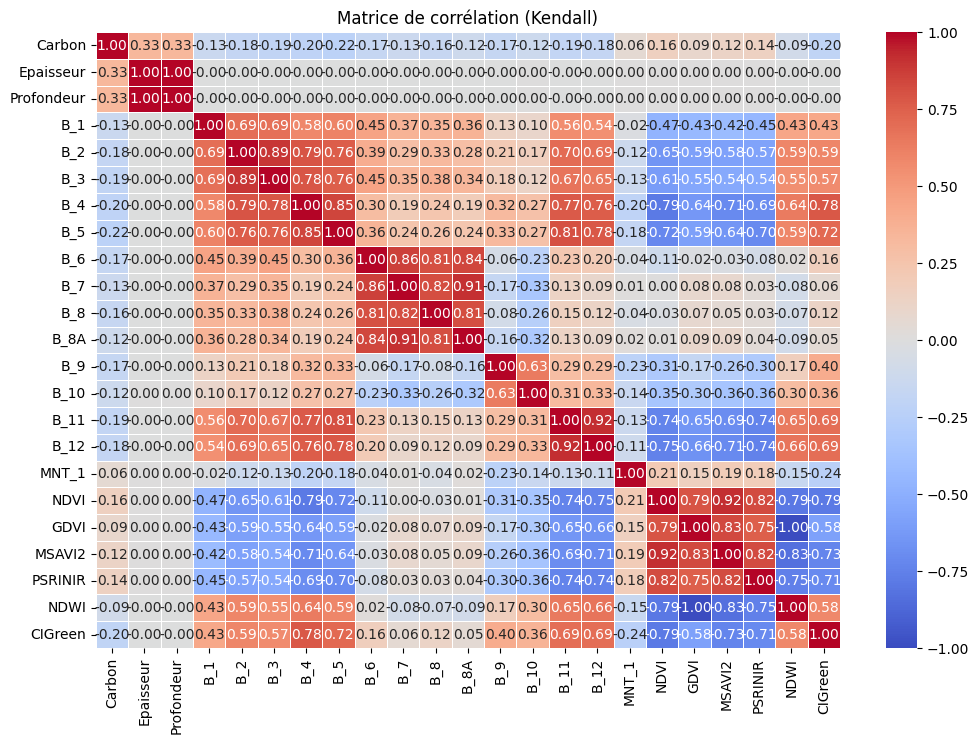

In [15]:
correlation_matrix = data.corr(method='kendall')

plt.figure(figsize=(12, 8))

# Tracer la heatmap de la matrice de corrélation
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Ajouter un titre
plt.title("Matrice de corrélation (Kendall)")

# Afficher la figure
plt.show()

In [16]:
import numpy as np

X = np.array(data.drop(columns=['Carbon']))
Y = np.array(data['Carbon'])

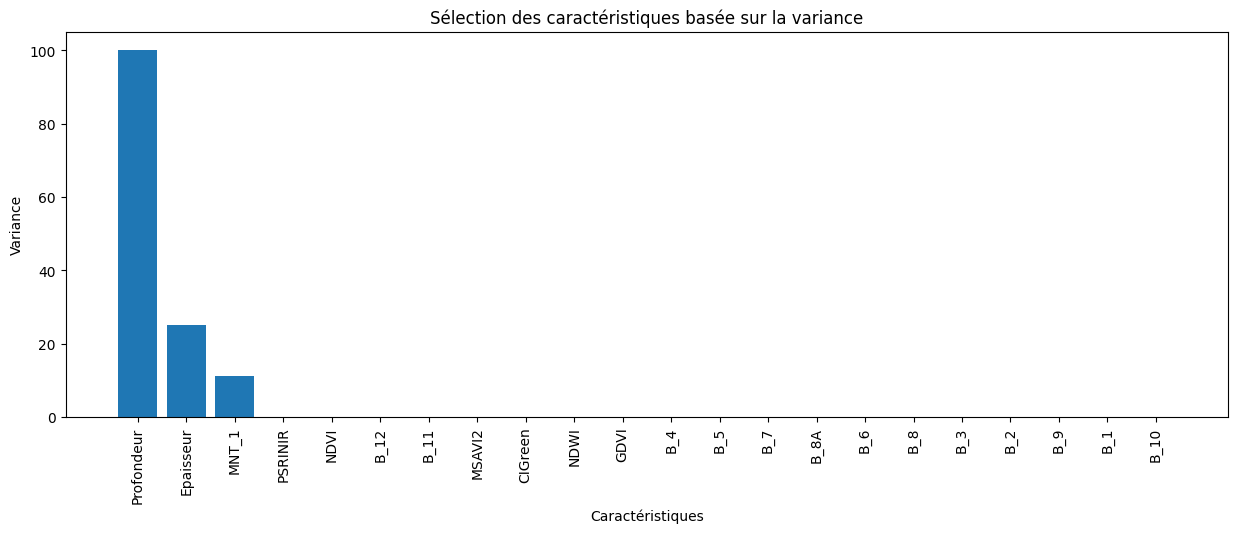

In [17]:
variances = np.var(X, axis=0)
sorted_indices = np.argsort(variances)[::-1]

# Obtenir les noms des colonnes
columns = data.drop(columns=['Carbon']).columns

# Afficher la courbe des variances
plt.figure(figsize=(15, 5))
plt.bar(x=columns[sorted_indices], height=variances[sorted_indices])
plt.xticks(rotation=90)
plt.xlabel('Caractéristiques')
plt.ylabel('Variance')
plt.title('Sélection des caractéristiques basée sur la variance')
plt.show()

In [18]:
from sklearn.feature_selection import SelectKBest, f_classif,f_regression

# Sélectionner les meilleures caractéristiques avec SelectKBest et ANOVA
best_features = SelectKBest(score_func=f_regression, k=6)
X_new = best_features.fit_transform(X, Y)
selected_features = columns[best_features.get_support()]

print('Les meilleures caractéristiques sont :', selected_features)

Les meilleures caractéristiques sont : Index(['Epaisseur', 'Profondeur', 'B_4', 'B_5', 'B_6', 'CIGreen'], dtype='object')


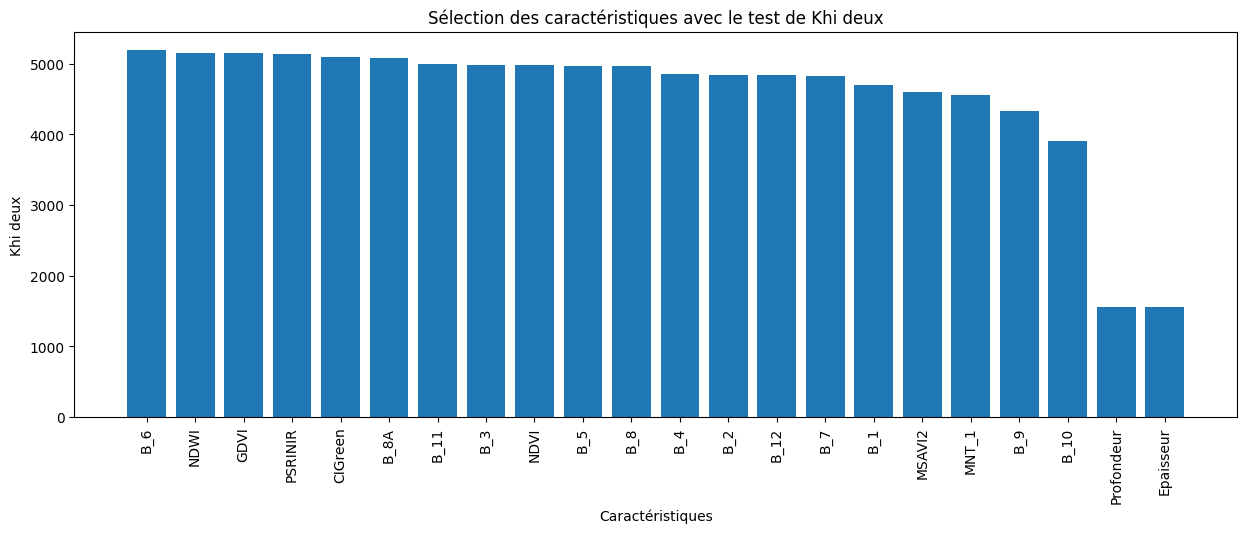

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import chi2_contingency


# Discrétiser les colonnes
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
X_discrete = discretizer.fit_transform(X)

# Calculer les scores de Khi deux pour chaque caractéristique
chi2_scores = np.array([chi2_contingency(pd.crosstab(X_discrete[:, i], Y))[0] for i in range(X_discrete.shape[1])])
sorted_indices = np.argsort(chi2_scores)[::-1]

# Afficher la courbe des scores de Khi deux
plt.figure(figsize=(15, 5))
plt.bar(x=columns[sorted_indices], height=chi2_scores[sorted_indices])
plt.xticks(rotation=90)
plt.xlabel('Caractéristiques')
plt.ylabel("Khi deux")
plt.title('Sélection des caractéristiques avec le test de Khi deux')
plt.show()


In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Diviser les données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Créer un objet modèle de régression linéaire
regression_model = LinearRegression()

# Forward Selection
sfs = SFS(regression_model, k_features='best', forward=True, floating=False, scoring='neg_mean_squared_error', cv=5)
sfs = sfs.fit(X_train, y_train)

# Afficher les résultats
print("Forward Selection: \nMeilleures caractéristiques:", columns[list(sfs.k_feature_idx_)], "\nMeilleur score (neg_mean_squared_error):", -sfs.k_score_)


Forward Selection: 
Meilleures caractéristiques: Index(['Epaisseur', 'B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8',
       'B_8A', 'B_9', 'B_10', 'B_11', 'B_12', 'MNT_1', 'NDVI', 'GDVI',
       'PSRINIR', 'CIGreen'],
      dtype='object') 
Meilleur score (neg_mean_squared_error): 8.120195033936808


In [21]:
# Backward Selection
sfs = SFS(regression_model, k_features='best', forward=False, floating=False, scoring='neg_mean_squared_error', cv=5)
sfs = sfs.fit(X_train, y_train)

# Afficher les résultats
print("Forward Selection: \nMeilleures caractéristiques:", columns[list(sfs.k_feature_idx_)], "\nMeilleur score (neg_mean_squared_error):", -sfs.k_score_)


Forward Selection: 
Meilleures caractéristiques: Index(['Epaisseur', 'Profondeur', 'B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6',
       'B_7', 'B_8A', 'B_9', 'B_10', 'B_11', 'B_12', 'MNT_1', 'NDVI', 'GDVI',
       'MSAVI2', 'CIGreen'],
      dtype='object') 
Meilleur score (neg_mean_squared_error): 8.102798457363786


In [22]:
# Recursive Feature Elimination
from sklearn.feature_selection import RFECV

rfe = RFECV(regression_model, step=1, cv=5, scoring='neg_mean_squared_error')
rfe = rfe.fit(X_train, y_train)
print("\nRecursive Feature Elimination: \nMeilleures caractéristiques:", columns[np.where(rfe.support_)[0]], "\nMeilleur score:", -rfe.cv_results_["mean_test_score"].max())


Recursive Feature Elimination: 
Meilleures caractéristiques: Index(['Epaisseur', 'Profondeur', 'B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6',
       'B_7', 'B_8', 'B_8A', 'B_9', 'B_10', 'B_11', 'B_12', 'MNT_1', 'NDVI',
       'GDVI', 'MSAVI2', 'PSRINIR', 'NDWI', 'CIGreen'],
      dtype='object') 
Meilleur score: 8.124922823716261


In [23]:
!pip install pykrige

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 854.9/854.9 kB 11.3 MB/s eta 0:00:00


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

In [28]:
path = '/content/MyDrive/MyDrive/GEE_SOP/Dataset/Data_to_Analyze.csv'

#sob_data = gpd.read_file(sob_shapefile_path)
data = pd.read_csv(path)

median_mnt1 = data['MNT_1'].median()
data['MNT_1'] = data['MNT_1'].fillna(median_mnt1)

In [29]:
data_10 = data[data['Profondeur'] == 10]
data_30 = data[data['Profondeur'] == 30]

In [30]:
x_coords_10 = data_10['X_Centroid']
y_coords_10 = data_10['Y_Centroid']

x_coords_30 = data_30['X_Centroid']
y_coords_30 = data_30['Y_Centroid']

Carbon_10 = data_10['Carbon']
Carbon_30 = data_30['Carbon']

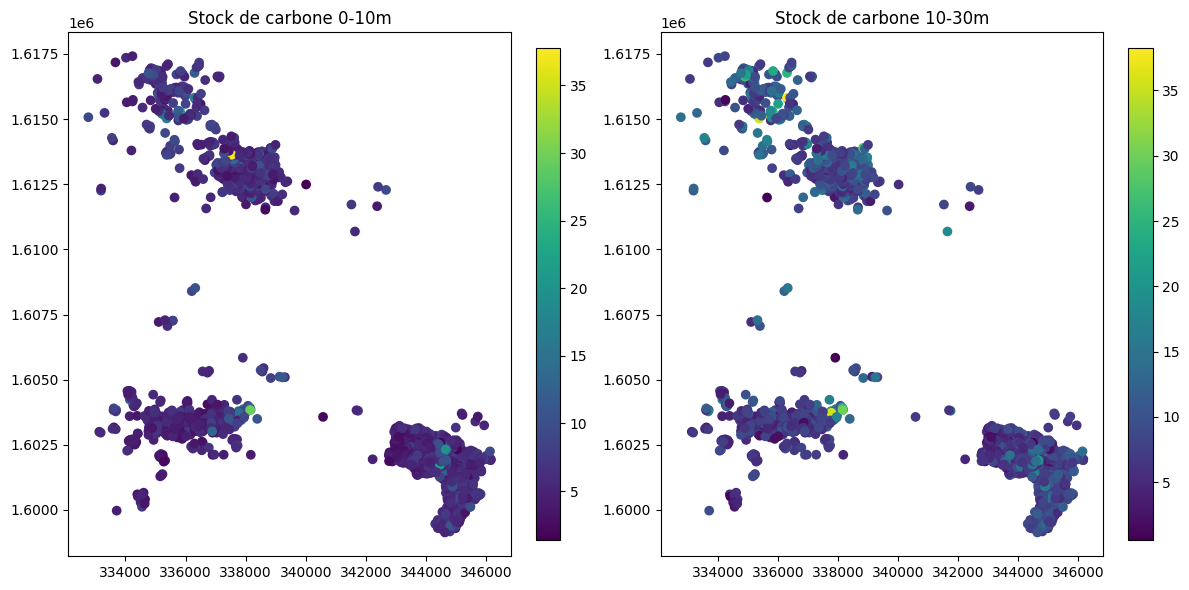

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Affichage du premier graphique
cax1 = axs[0].scatter(x_coords_10, y_coords_10, c=Carbon_10)
cbar1 = plt.colorbar(cax1, ax=axs[0], fraction=0.05)
axs[0].set_title('Stock de carbone 0-10m')

# Affichage du deuxième graphique
cax2 = axs[1].scatter(x_coords_30, y_coords_30, c=Carbon_30)
cbar2 = plt.colorbar(cax2, ax=axs[1], fraction=0.05)
axs[1].set_title('Stock de carbone 10-30m')

plt.tight_layout()
plt.show()


In [32]:
!pip install scikit-gstat -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.3/708.3 kB 11.8 MB/s eta 0:00:00


In [33]:
from sklearn.model_selection import cross_val_score
from skgstat import Variogram
import numpy as np

#les modèles de variogramme à tester
models = ['spherical', 'exponential', 'gaussian', 'linear', 'power']

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 1.6397717097475066
Full Sill: 6.929756230875784
Range: 4129.489426264255
Nugget: 5.289984521128277 



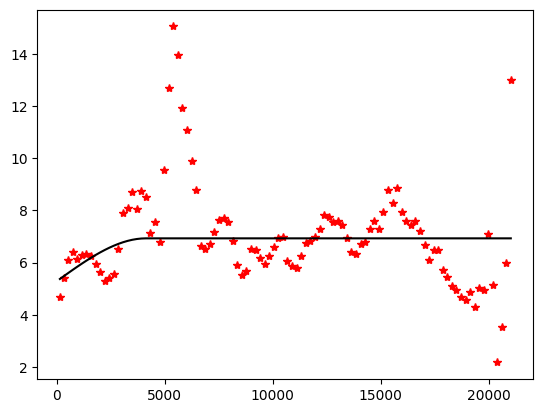

Calculating statistics on variogram model fit...
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 2.17712461112608
Full Sill: 6.900990543689005
Range: 2932.3420251356747
Nugget: 4.7238659325629255 



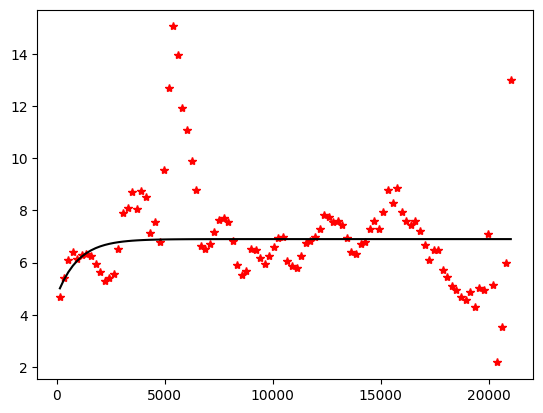

Calculating statistics on variogram model fit...
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 1.3462520342777793
Full Sill: 6.926954519103265
Range: 3674.828190465306
Nugget: 5.580702484825485 



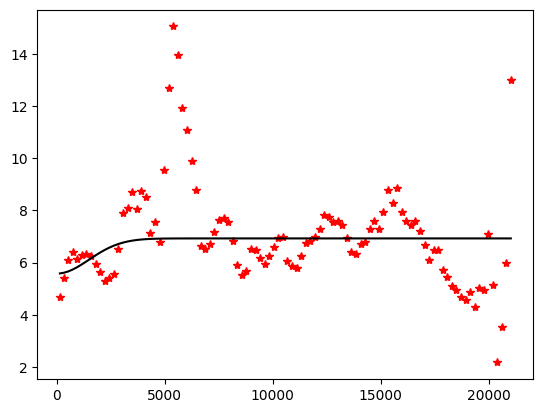

Calculating statistics on variogram model fit...
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 3.673536666303468e-22
Nugget: 6.771795035825917 



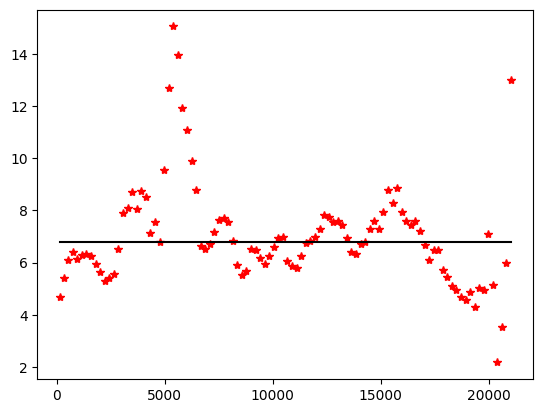

Calculating statistics on variogram model fit...
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'power' Variogram Model
Scale: 5.821906957120702
Exponent: 0.016861769511890192
Nugget: 1.8958937695218e-06 



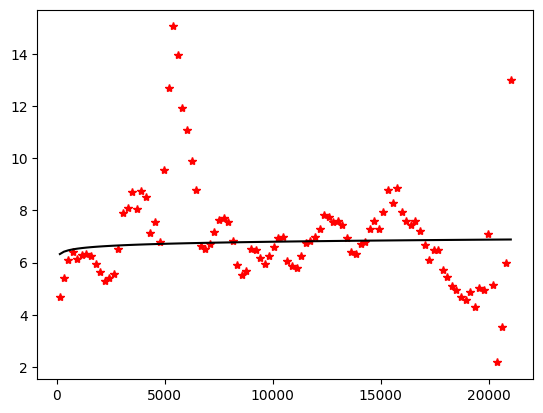

Calculating statistics on variogram model fit...


In [34]:
for model in models:
  OrdinaryKriging(
      x_coords_10,
      y_coords_10,
      Carbon_10,
      variogram_model=model,
      verbose=True,
      enable_plotting=True,
      nlags=100,
  )

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 8.996485782655487
Full Sill: 16.95706281848078
Range: 3971.546198966038
Nugget: 7.960577035825291 



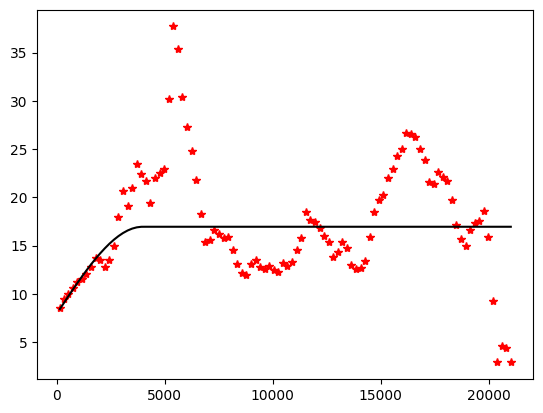

Calculating statistics on variogram model fit...
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 10.297942827982226
Full Sill: 16.772014124181215
Range: 3900.222767055846
Nugget: 6.47407129619899 



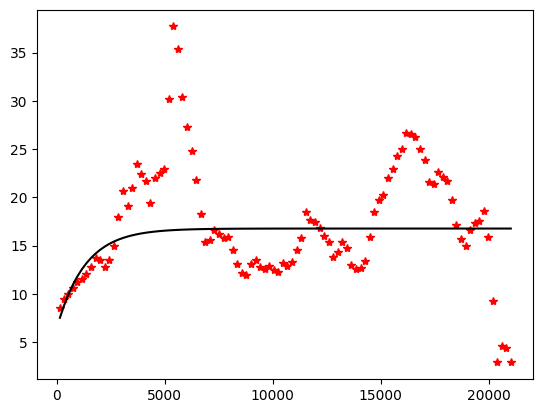

Calculating statistics on variogram model fit...
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 7.8527272099709595
Full Sill: 16.960330286892813
Range: 3364.8162779833374
Nugget: 9.107603076921853 



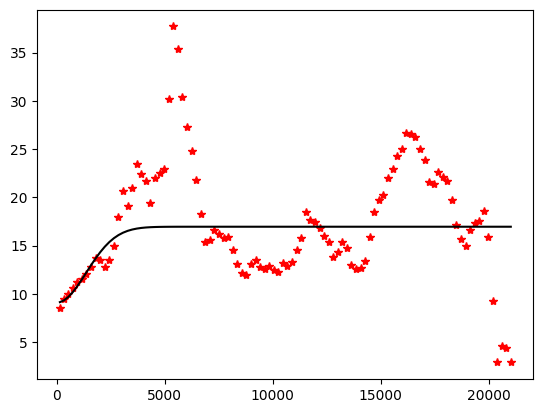

Calculating statistics on variogram model fit...
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'linear' Variogram Model
Slope: 0.00017122922577507383
Nugget: 14.19672009949991 



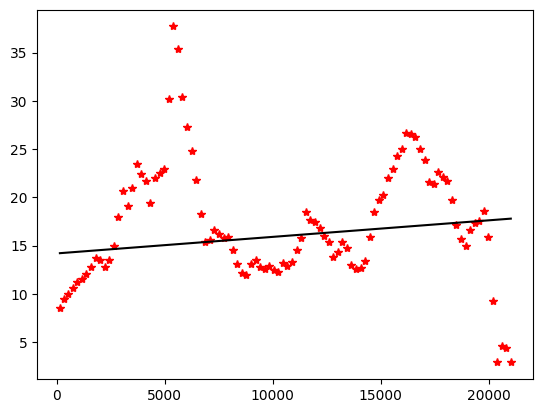

Calculating statistics on variogram model fit...
Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'power' Variogram Model
Scale: 5.750798198314954
Exponent: 0.11337761774261146
Nugget: 5.95071281569057e-15 



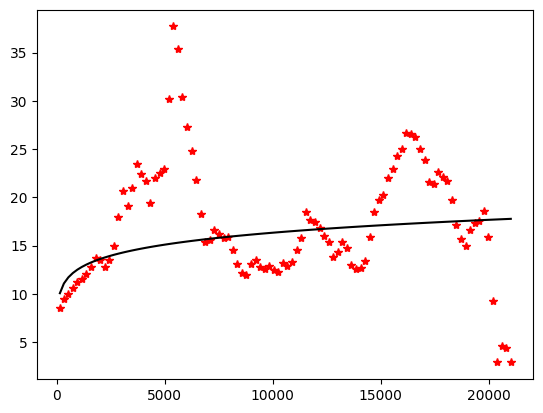

Calculating statistics on variogram model fit...


In [35]:
for model in models:
  OrdinaryKriging(
      x_coords_30,
      y_coords_30,
      Carbon_30,
      variogram_model=model,
      verbose=True,
      enable_plotting=True,
      nlags=100,
  )

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 1.351115083091369
Full Sill: 6.883729502362364
Range: 4341.979580228482
Nugget: 5.5326144192709945 



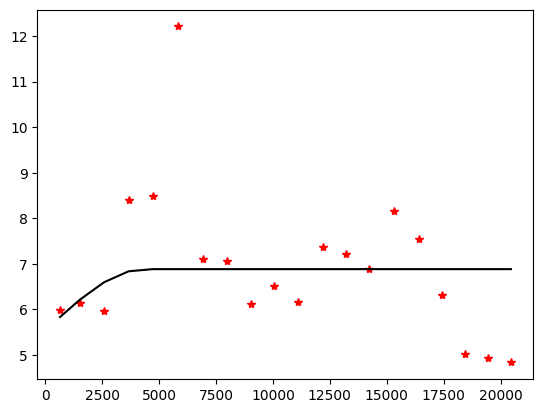

Calculating statistics on variogram model fit...


In [36]:
OK1 = OrdinaryKriging(
    x_coords_10,
    y_coords_10,
    Carbon_10,
    variogram_model='spherical',
    verbose=True,
    enable_plotting=True,
    nlags=20,
)

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 9.084332900817186
Full Sill: 16.974367295756956
Range: 3929.0752718625936
Nugget: 7.8900343949397715 



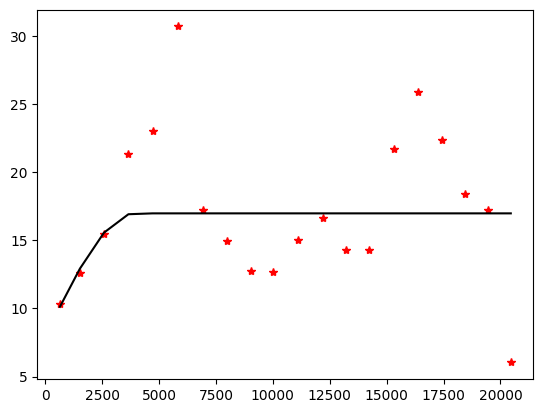

Calculating statistics on variogram model fit...


In [37]:
OK2 = OrdinaryKriging(
    x_coords_30,
    y_coords_30,
    Carbon_30,
    variogram_model='spherical',
    verbose=True,
    enable_plotting=True,
    nlags=20,
)

In [38]:
OK1.variogram_model_parameters, OK2.variogram_model_parameters

(array([1.35111508e+00, 4.34197958e+03, 5.53261442e+00]),
 array([   9.0843329 , 3929.07527186,    7.89003439]))

In [39]:
# Définir une grille de points pour l'interpolation
gridx = np.linspace(min(x_coords_10), max(x_coords_10), 100)
gridy = np.linspace(min(y_coords_10), max(y_coords_10), 100)

# Effectuer l'interpolation sur la grille
z_interp1, ss1 = OK1.execute('grid', gridx, gridy)

z_interp2, ss2 = OK2.execute('grid', gridx, gridy)

Executing Ordinary Kriging...

Executing Ordinary Kriging...



In [40]:
z_interp1.shape,ss1.shape,z_interp2.shape,ss2.shape

((100, 100), (100, 100), (100, 100), (100, 100))

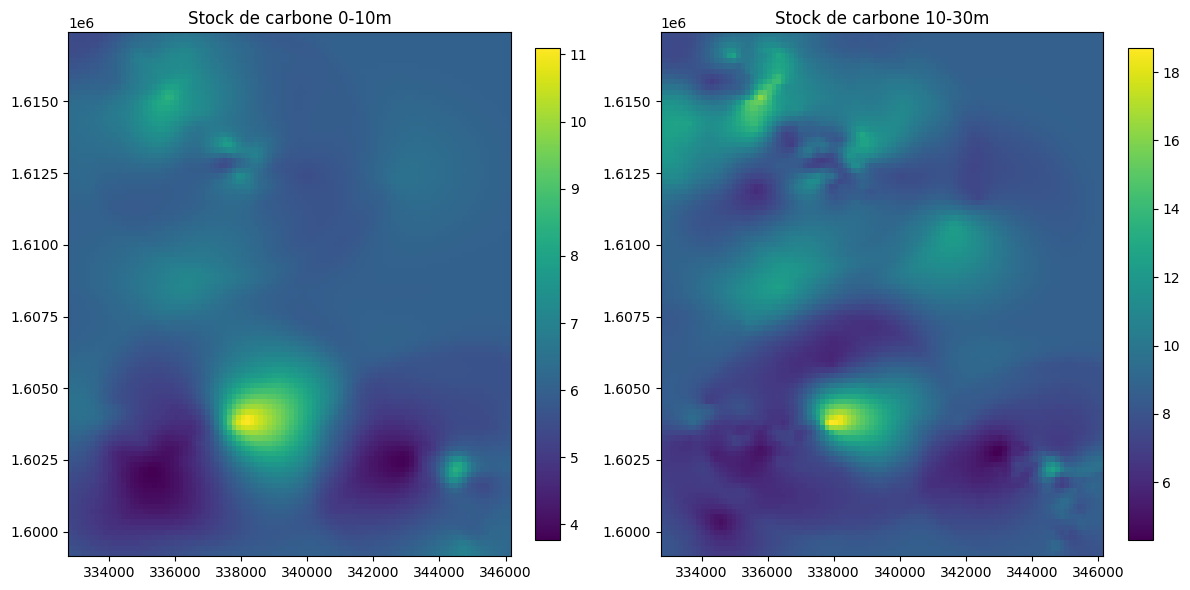

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Affichage du premier graphique
cax1 = axs[0].imshow(z_interp1, extent=(min(x_coords_10), max(x_coords_10), min(y_coords_10), max(y_coords_10)), origin='lower', aspect='auto')
#axs[0].scatter(x, y, c=carbon_1, marker='.')
cbar1 = plt.colorbar(cax1, ax=axs[0], fraction=0.05)
axs[0].set_title('Stock de carbone 0-10m')

# Affichage du deuxième graphique
cax2 = axs[1].imshow(z_interp2, extent=(min(x_coords_10), max(x_coords_10), min(y_coords_10), max(y_coords_10)), origin='lower', aspect='auto')
#axs[1].scatter(x, y, c=carbon_2, marker='.')
cbar2 = plt.colorbar(cax2, ax=axs[1], fraction=0.05)
axs[1].set_title('Stock de carbone 10-30m')

plt.tight_layout()
plt.show()


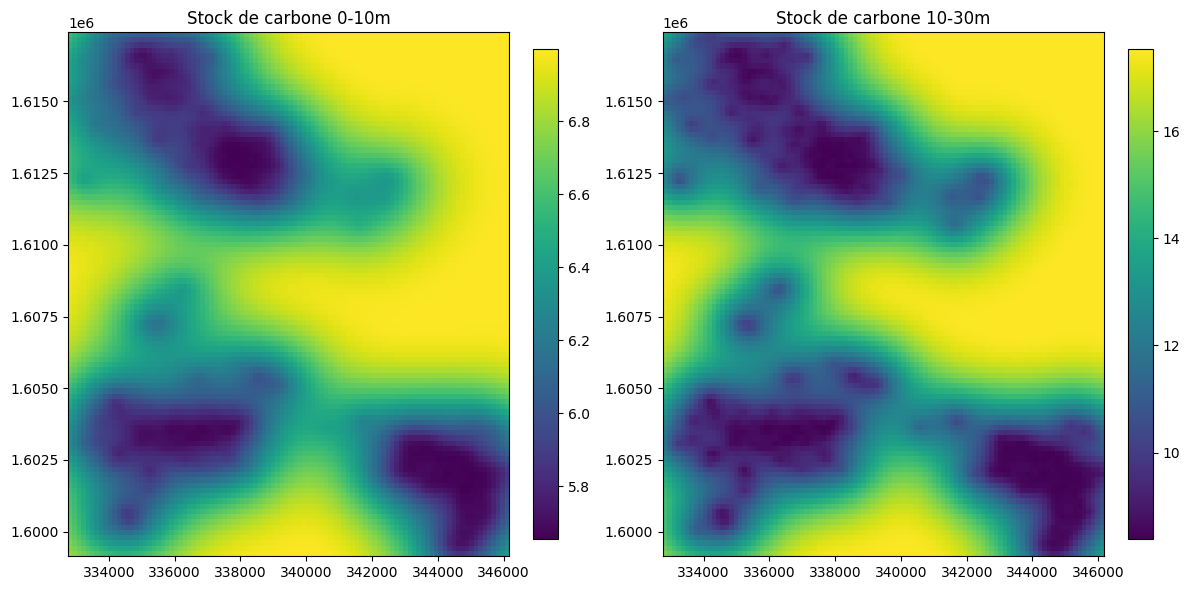

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Affichage du premier graphique
cax1 = axs[0].imshow(ss1, extent=(min(x_coords_10), max(x_coords_10), min(y_coords_10), max(y_coords_10)), origin='lower', aspect='auto')
#axs[0].scatter(x, y, c=carbon_1, marker='.')
cbar1 = plt.colorbar(cax1, ax=axs[0], fraction=0.05)
axs[0].set_title('Stock de carbone 0-10m')

# Affichage du deuxième graphique
cax2 = axs[1].imshow(ss2, extent=(min(x_coords_10), max(x_coords_10), min(y_coords_10), max(y_coords_10)), origin='lower', aspect='auto')
#axs[1].scatter(x, y, c=carbon_2, marker='.')
cbar2 = plt.colorbar(cax2, ax=axs[1], fraction=0.05)
axs[1].set_title('Stock de carbone 10-30m')

plt.tight_layout()
plt.show()
